In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    classification_report
)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
class ASLCNN(nn.Module):
    def __init__(self, num_classes=26):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),     # 14×14

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),     # 7×7

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),     # 3×3
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [4]:
val_dir = "../data/cnn/val"   # e.g. data/val/A, data/val/B, ...

classes = sorted(os.listdir(val_dir))
num_classes = len(classes)

print("Classes:", classes)
print("Num classes:", num_classes)

transform = transforms.Compose([
    transforms.Resize((28, 28)),   # 🔥 MUST be 28×28
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False
)

print("Validation samples:", len(val_dataset))


Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Num classes: 36
Validation samples: 38111


In [5]:
cnn = ASLCNN(num_classes=num_classes)
cnn.load_state_dict(
    torch.load("cnn/asl_cnn.pth", map_location=device)
)
cnn.to(device)
cnn.eval()

print("✅ CNN loaded successfully")


✅ CNN loaded successfully


d:\Computer Vision\ASL Recognition\asl_env\Lib\site-packages\torch\cuda\__init__.py:287: UserWarning: 
NVIDIA GeForce RTX 5060 Laptop GPU with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5060 Laptop GPU GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


In [6]:
all_preds = []
all_labels = []

start_time = time.time()

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = cnn(images)
        preds = outputs.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

end_time = time.time()

elapsed = end_time - start_time
fps = len(val_dataset) / elapsed


In [7]:
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)

print("Evaluation Complete")
print(f"Classes: {num_classes}")
print(f"FPS: {fps:.2f}")
print(f"Mean Precision: {np.mean(precision):.3f}")
print(f"Mean Recall: {np.mean(recall):.3f}")

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))


Evaluation Complete
Classes: 36
FPS: 622.05
Mean Precision: 0.361
Mean Recall: 0.330

Classification Report:

              precision    recall  f1-score   support

           0       0.08      0.07      0.07        14
           1       0.00      0.00      0.00        14
           2       0.05      0.07      0.06        14
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00        14
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00        14
           9       0.00      0.00      0.00        14
           a       0.53      0.39      0.45      1566
           b       0.48      0.60      0.54      1536
           c       0.58      0.74      0.65      1504
           d       0.71      0.62      0.66      1400
           e       0.54      0.23      0.32      1423
           f       0.59  

d:\Computer Vision\ASL Recognition\asl_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Computer Vision\ASL Recognition\asl_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Computer Vision\ASL Recognition\asl_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

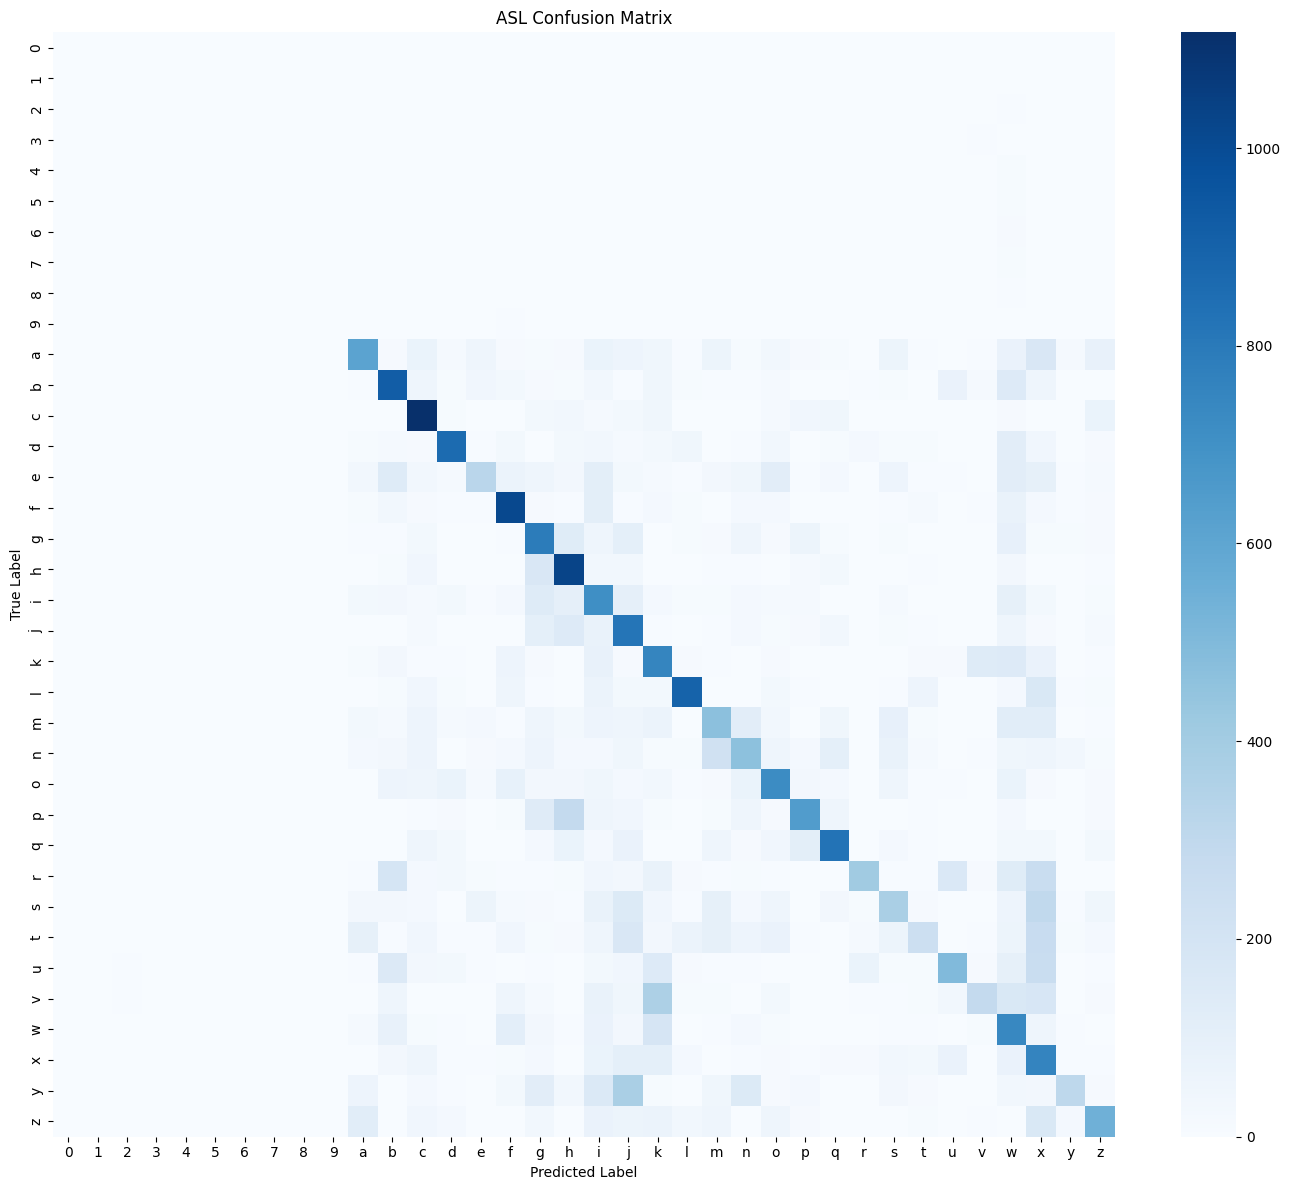

In [8]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    xticklabels=classes,
    yticklabels=classes,
    cmap="Blues",
    fmt="d"
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("ASL Confusion Matrix")
plt.tight_layout()
plt.show()


In [9]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)

for cls, acc in zip(classes, class_accuracy):
    print(f"{cls}: {acc:.3f}")


0: 0.071
1: 0.000
2: 0.071
3: 0.000
4: 0.000
5: 0.000
6: 0.000
7: 0.000
8: 0.000
9: 0.000
a: 0.391
b: 0.600
c: 0.743
d: 0.616
e: 0.226
f: 0.684
g: 0.549
h: 0.709
i: 0.483
j: 0.593
k: 0.518
l: 0.614
m: 0.323
n: 0.319
o: 0.481
p: 0.466
q: 0.564
r: 0.275
s: 0.253
t: 0.165
u: 0.337
v: 0.204
w: 0.516
x: 0.507
y: 0.204
z: 0.403


In [10]:
import pandas as pd
from sklearn.metrics import classification_report

# generate report as dictionary
report_dict = classification_report(
    all_labels,
    all_preds,
    target_names=classes,
    output_dict=True
)

# convert to DataFrame
df_report = pd.DataFrame(report_dict).transpose()

# save to CSV
csv_path = "asl_classification_report.csv"
df_report.to_csv(csv_path)

print(f"✅ Classification report saved to {csv_path}")


✅ Classification report saved to asl_classification_report.csv


d:\Computer Vision\ASL Recognition\asl_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Computer Vision\ASL Recognition\asl_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Computer Vision\ASL Recognition\asl_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize